# Clustering particles

In [1]:
# Libraries ----
import sys  # type: ignore
import imageio  # type: ignore
import warnings
import numpy as np  # type: ignore
import pandas as pd  # type: ignore

from tqdm import tqdm  # type: ignore

sys.path.append('../modules')
import track_particles as tp  # type: ignore
import plot_tracking as plt_tp  # type: ignore
import plot_clustering as plt_cp  # type: ignore
import clustering_particles as cp  # type: ignore

# Global options ----
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)

## Global variables

In [2]:
input_path = "../input_files"
output_path = "../output_files"
log_path = "../logs"
input_generation_date = "2025-02-18"

video_name = "3n_2m_1f_230404_1"
n_particles = int(video_name[0])
save_figures = True
save_tracking = True
x_bounds = [0, 1080]
y_bounds = [50, 1870]
x_zoom = [0, 1080]
y_zoom = [0, 1920]

## Setting video information

In [3]:
# Load the video
reader = imageio.get_reader("{}/{}.mp4".format(input_path, video_name), "ffmpeg")

# Check the number of frames
num_frames = reader.count_frames()
print("Total frames: {}".format(num_frames))

# Extract a frame to inspect the content
time = 0
frame = reader.get_data(time)
print("Frames resolution: {} x {}".format(frame.shape[0], frame.shape[1]))

Total frames: 68400
Frames resolution: 1080 x 1920


In [4]:
df_tracked = pd.concat([
    pd.read_csv("{}/tracked_{}_0.csv".format(output_path, video_name), low_memory=False),
    pd.read_csv("{}/tracked_{}_1.csv".format(output_path, video_name), low_memory=False),
    pd.read_csv("{}/tracked_{}_2.csv".format(output_path, video_name), low_memory=False)#,
    # pd.read_csv("{}/tracked_{}_3.csv".format(output_path, video_name), low_memory=False)#,
    # pd.read_csv("{}/tracked_{}_4.csv".format(output_path, video_name), low_memory=False),
    # pd.read_csv("{}/tracked_{}_5.csv".format(output_path, video_name), low_memory=False),
    # pd.read_csv("{}/tracked_{}_6.csv".format(output_path, video_name), low_memory=False),
    #pd.read_csv("{}/tracked_{}_7.csv".format(output_path, video_name), low_memory=False),
    # pd.read_csv("{}/tracked_{}_8.csv".format(output_path, video_name), low_memory=False)
]).sort_values(["id", "time"])

In [5]:
if "coords_x" in df_tracked.columns:
    df_tracked["coords_x"] = df_tracked["coords_x"].apply(lambda x: np.fromstring(x, sep=" "))
    df_tracked["coords_y"] = df_tracked["coords_y"].apply(lambda x: np.fromstring(x, sep=" "))
df_tracked.sort_values(["time", "id"]).head(2 * n_particles)

,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count
0,0,0,1804.404810,34.068136,1804.409686,34.165673,0.0,1789.000000,8.000000,0.368627,1786.000000,0.000000,0.129207,1497.0,96.996517,28.284914,0.956538,6
1,1,0,1486.728940,147.959019,1469.665152,147.024816,0.0,1476.000000,102.000000,0.517647,1548.000000,176.000000,-1.528609,15373.0,246.752541,90.076766,0.930988,6
2,2,0,1711.787748,399.336216,1709.878740,404.135068,NaN,1711.787748,399.336216,NaN,1711.787748,399.336216,-0.056153,2775.0,177.813400,80.173680,0.892581,6
3,3,0,1711.614925,526.955600,1709.537356,531.150816,NaN,1711.614925,526.955600,NaN,1711.614925,526.955600,-0.204139,8536.0,167.370882,68.859411,0.911447,6
4,4,0,1660.838686,941.598300,1657.665981,942.384271,NaN,1660.838686,941.598300,NaN,1660.838686,941.598300,0.857466,13886.0,247.304681,96.601980,0.920552,6
5,5,0,509.449708,1070.695335,509.618048,1070.693935,0.0,467.000000,1061.000000,0.666667,458.000000,1067.000000,1.540573,1372.0,112.510933,19.044154,0.985571,6


In [6]:
# Manual Setup for time = 0
tracking_0 = df_tracked[df_tracked["time"] == 0]
cols = ["id", "time", "id_count", "position_x", "position_y", "orientation"]
print("Initial tracking at time 0:\n", tracking_0[cols])

if tracking_0.shape[0] != n_particles:
    # Manual fitting of initial time tracking
    tracking_0 = tracking_0.drop_duplicates(subset=["id"], keep="first")
    tracking_0 = tracking_0[tracking_0["id"].isin([1, 3, 4])]
    tracking_0["id"] = np.arange(n_particles)
    tracking_0["orientation"] = np.array([
        tracking_0["orientation"].values[0],
        -tracking_0["orientation"].values[1],
        tracking_0["orientation"].values[2]
    ])

    # Replace the manual setting
    df_tracked = pd.concat([
        tracking_0,
        df_tracked[df_tracked["time"] != 0]
    ]).sort_values(["id", "time"])

df_tracked.sort_values(["time", "id"]).head(2 * n_particles + 1)

Initial tracking at time 0:
    id  time  id_count   position_x   position_y  orientation
0   0     0         6  1804.404810    34.068136     0.129207
1   1     0         6  1486.728940   147.959019    -1.528609
2   2     0         6  1711.787748   399.336216    -0.056153
3   3     0         6  1711.614925   526.955600    -0.204139
4   4     0         6  1660.838686   941.598300     0.857466
5   5     0         6   509.449708  1070.695335     1.540573


,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count
1,0,0,1486.728940,147.959019,1469.665152,147.024816,0.0,1476.000000,102.000000,0.517647,1548.000000,176.000000,-1.528609,15373.0,246.752541,90.076766,0.930988,6
3,1,0,1711.614925,526.955600,1709.537356,531.150816,NaN,1711.614925,526.955600,NaN,1711.614925,526.955600,0.204139,8536.0,167.370882,68.859411,0.911447,6
4,2,0,1660.838686,941.598300,1657.665981,942.384271,NaN,1660.838686,941.598300,NaN,1660.838686,941.598300,0.857466,13886.0,247.304681,96.601980,0.920552,6
6,0,3,1804.331812,33.837679,1804.329840,33.922765,0.0,1810.000000,8.000000,0.368627,1786.000000,0.000000,0.123274,1534.0,95.221339,28.333669,0.954704,5
7,1,3,1486.505365,148.195346,1469.463801,147.553996,0.0,1476.000000,102.000000,0.517647,1520.000000,176.000000,-1.524831,15470.0,246.889766,90.647556,0.930159,5
8,2,3,1714.655212,392.456663,1714.091260,393.970780,NaN,1714.655212,392.456663,NaN,1714.655212,392.456663,0.225182,2619.0,142.179198,65.034643,0.889254,5
9,3,3,1713.170943,527.236681,1711.572922,531.736339,NaN,1713.170943,527.236681,NaN,1713.170943,527.236681,-0.211180,8184.0,170.114269,63.021806,0.928845,5


In [7]:
df_tracked.sort_values(["time", "id"]).tail(5)

,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count
10785,3,68394,1545.066598,926.273848,1543.664569,931.360524,NaN,1545.066598,926.273848,NaN,1545.066598,926.273848,-0.004066,9655.0,167.486393,76.842734,0.888540,4
10786,0,68397,1435.608085,104.306984,1426.254552,105.844961,0.0,1398.000000,53.000000,0.564706,1422.000000,99.000000,-1.540963,14447.0,241.483294,98.548863,0.912938,4
10787,1,68397,1523.463524,789.553311,1521.167371,784.152017,0.0,1488.000000,727.000000,0.521569,1489.000000,727.000000,0.221754,3564.0,101.538774,66.268350,0.757667,4
10788,2,68397,1709.613333,880.067413,1705.061388,899.366726,NaN,1709.613333,880.067413,NaN,1709.613333,880.067413,-0.189805,9375.0,301.415199,69.754195,0.972853,4
10789,3,68397,1545.062157,926.263752,1543.658523,931.337795,NaN,1545.062157,926.263752,NaN,1545.062157,926.263752,-0.003853,9653.0,167.518745,76.818583,0.888660,4


## Velocities distribution in each frame

In [8]:
omega_threshold = np.pi / 2 # Angular velocity per frame
velocity_threshold = 94.0 # Velocity per frame limited with half average size of particle
print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi)

# Compute differences for each id
df_tracked["delta_time"] = df_tracked.groupby(["id"])["time"].diff()
df_tracked["velocity_x"] = df_tracked.groupby(["id"])["position_x"].diff()
df_tracked["velocity_y"] = df_tracked.groupby(["id"])["position_y"].diff()
df_tracked["velocity_orientation"] = df_tracked.groupby(["id"])["orientation"].diff()

# Compute velocity components (change in position divided by change in time)
df_tracked["velocity_x"] = df_tracked["velocity_x"] / df_tracked["delta_time"]
df_tracked["velocity_y"] = df_tracked["velocity_y"] / df_tracked["delta_time"]
df_tracked["velocity_orientation"] = df_tracked["velocity_orientation"] / df_tracked["delta_time"]

# Filter short jumps (highest velocities are False)
df_tracked["mask_x"] = np.where(np.abs(df_tracked["velocity_x"]) <= velocity_threshold, True, False)
df_tracked["mask_y"] = np.where(np.abs(df_tracked["velocity_y"]) <= velocity_threshold, True, False)
df_tracked["mask_orientation"] = np.where(np.abs(df_tracked["velocity_orientation"]) <= omega_threshold, True, False)


Thresholds:
	- Velocity: 94.0 
	- Angle: 90.0


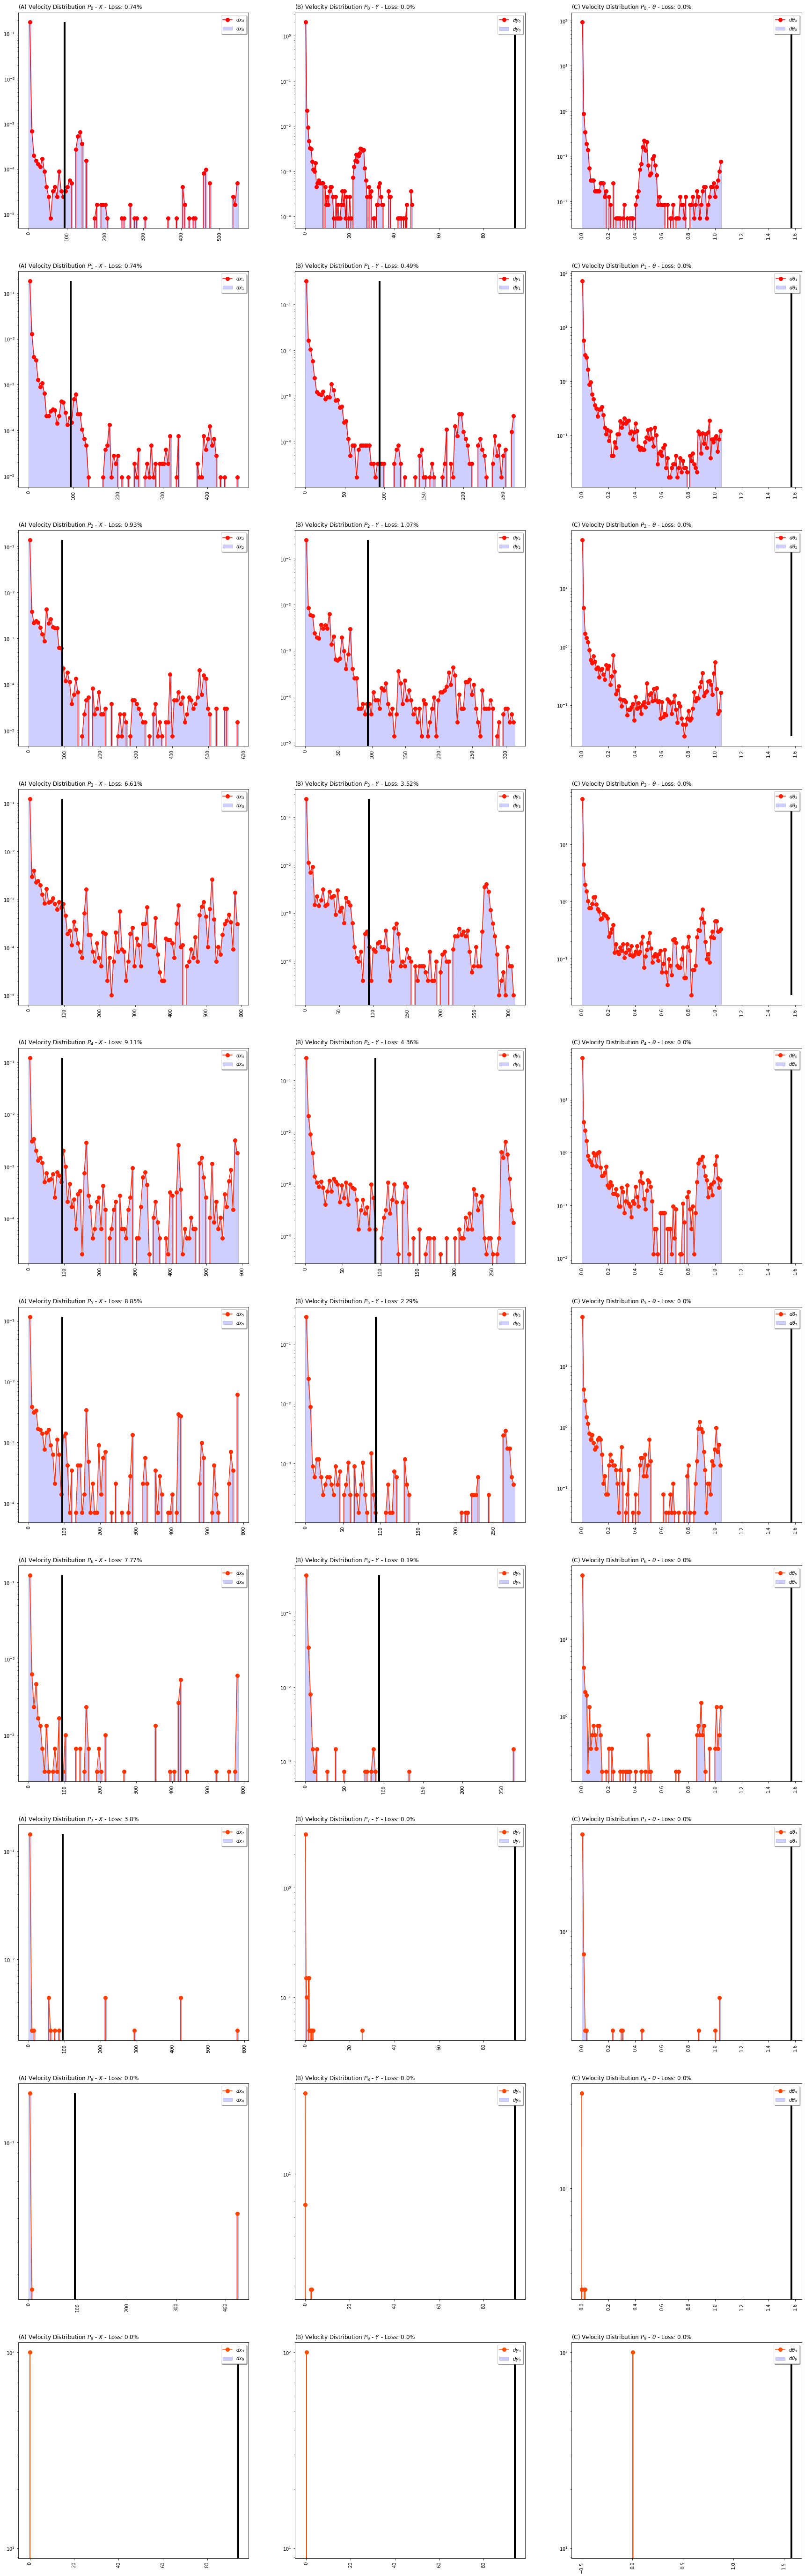

In [9]:
bins = 100
width = 10
fancy_legend = True

plt_cp.plot_velocities_distribution(
    df_tracked=df_tracked,
    bins=bins,
    velocity_threshold=velocity_threshold,
    omega_threshold=omega_threshold,
    width=width,
    fancy_legend=fancy_legend
)

In [10]:
df_tracked[["id_count"]].value_counts(dropna=False, sort=False, normalize=False).reset_index().sort_values("id_count")

,id_count,count
0,2,10
1,3,18570
2,4,34420
3,5,27785
4,6,11565
5,7,3052
6,8,552
7,9,72
8,10,20


## Clustering frames

In [11]:
# id_count = df_tracked["id_count"].max()
type = "local equalized"
clip_limit = 0.05
omega_threshold = df_tracked["velocity_orientation"].abs().quantile(0.965) # Angular velocity per frame
velocity_threshold = 100 # Velocity per frame limited with half average size of particle
compare_bounds = False
similarity_threshold = 0.85

print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi, "\n")
# ids = df_tracked[df_tracked["id_count"] != n_particles]["id_count"].unique()
# ids = sorted(np.sort(ids), key=lambda n: abs(n - n_particles))

df_clustered = cp.clustering_local_frames(
    reader=reader,
    df_tracked=df_tracked,
    weights_previous_time=[0],
    type=type,
    clip_limit=clip_limit,
    distance_threshold=velocity_threshold,
    compare_bounds=compare_bounds,
    similarity_threshold=similarity_threshold,
    n_particles=n_particles
)

Thresholds:
	- Velocity: 100 
	- Angle: 48.211330616820874 



In [12]:
df_clustered["id_count_new"] = df_clustered.groupby(["time"])["id"].transform("count")  # noqa: 501

### Explore final data

In [13]:
df_counts = (
    df_tracked[["id_count", "mask_x", "mask_y", "mask_orientation"]]
    .value_counts(dropna=False, sort=False, normalize=True)
    .reset_index()
    .sort_values(["id_count", "mask_x", "mask_y", "mask_orientation"])
)
df_counts["proportion"] = 100 * df_counts["proportion"]
df_counts

,id_count,mask_x,mask_y,mask_orientation,proportion
0,2,False,False,False,0.010412
1,3,False,False,False,19.081482
2,3,False,True,False,0.107240
3,3,True,False,False,0.077046
4,3,True,True,False,0.068717
5,4,False,False,False,34.688587
6,4,False,True,False,0.461237
7,4,True,False,False,0.559107
8,4,True,True,False,0.128064
9,5,False,False,False,27.518064


In [14]:
omega_threshold = df_tracked["velocity_orientation"].abs().quantile(0.965) # Angular velocity per frame
velocity_threshold = df_tracked["velocity_x"].abs().quantile(0.815) # Velocity per frame limited with half average size of particle
print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi, "\n")

# Compute differences for each id
df_clustered["delta_time"] = df_clustered.groupby(["id"])["time"].diff()
df_clustered["velocity_x"] = df_clustered.groupby(["id"])["position_x"].diff()
df_clustered["velocity_y"] = df_clustered.groupby(["id"])["position_y"].diff()
df_clustered["velocity_orientation"] = df_clustered.groupby(["id"])["orientation"].diff()

# Compute velocity components (change in position divided by change in time)
df_clustered["velocity_x"] = df_clustered["velocity_x"] / df_clustered["delta_time"]
df_clustered["velocity_y"] = df_clustered["velocity_y"] / df_clustered["delta_time"]
df_clustered["velocity_orientation"] = df_clustered["velocity_orientation"] / df_clustered["delta_time"]

# Filter short jumps (highest velocities are False)
df_clustered["mask_x"] = np.where(np.abs(df_clustered["velocity_x"]) <= velocity_threshold, True, False)
df_clustered["mask_y"] = np.where(np.abs(df_clustered["velocity_y"]) <= velocity_threshold, True, False)
df_clustered["mask_orientation"] = np.where(np.abs(df_clustered["velocity_orientation"]) <= omega_threshold, True, False)


Thresholds:
	- Velocity: 3.707983588725109 
	- Angle: 48.211330616820874 



In [15]:
df_counts = (
    df_clustered[["id_count_new", "mask_x", "mask_y", "mask_orientation"]]
    .value_counts(dropna=False, sort=False, normalize=True)
    .reset_index()
    .sort_values(["id_count_new", "mask_x", "mask_y", "mask_orientation"])
)
df_counts["proportion"] = 100 * df_counts["proportion"]

print("Final loss data : {}%".format(df_counts[df_counts["id_count_new"]!=n_particles]["proportion"].sum()))
print("Final loss data X-axis: {}%".format(df_counts[df_counts["mask_x"]==False]["proportion"].sum()))
print("Final loss data Y-axis: {}%".format(df_counts[df_counts["mask_y"]==False]["proportion"].sum()))
print("Final loss data Angle : {}%".format(df_counts[df_counts["mask_orientation"]==False]["proportion"].sum()))
df_counts

Final loss data : 0.0058483807295854956%
Final loss data X-axis: 5.962424153812414%
Final loss data Y-axis: 4.800058483807296%
Final loss data Angle : 0.8743329190730317%


,id_count_new,mask_x,mask_y,mask_orientation,proportion
0,2,True,True,True,0.005848
1,3,False,False,False,0.369910
2,3,False,False,True,2.775057
3,3,False,True,False,0.217852
4,3,False,True,True,2.599605
5,3,True,False,False,0.029242
6,3,True,False,True,1.625850
7,3,True,True,False,0.257329
8,3,True,True,True,92.119307


In [16]:
df_filter_clustered = df_clustered[df_clustered["id_count_new"] == n_particles]
df_filter_clustered["id_count"] = df_filter_clustered["id_count_new"]
df_filter_clustered = df_filter_clustered.drop(columns=["id_count_new"])

Thresholds:
	- Velocity: 3.707983588725109 
	- Angle: 48.211330616820874 



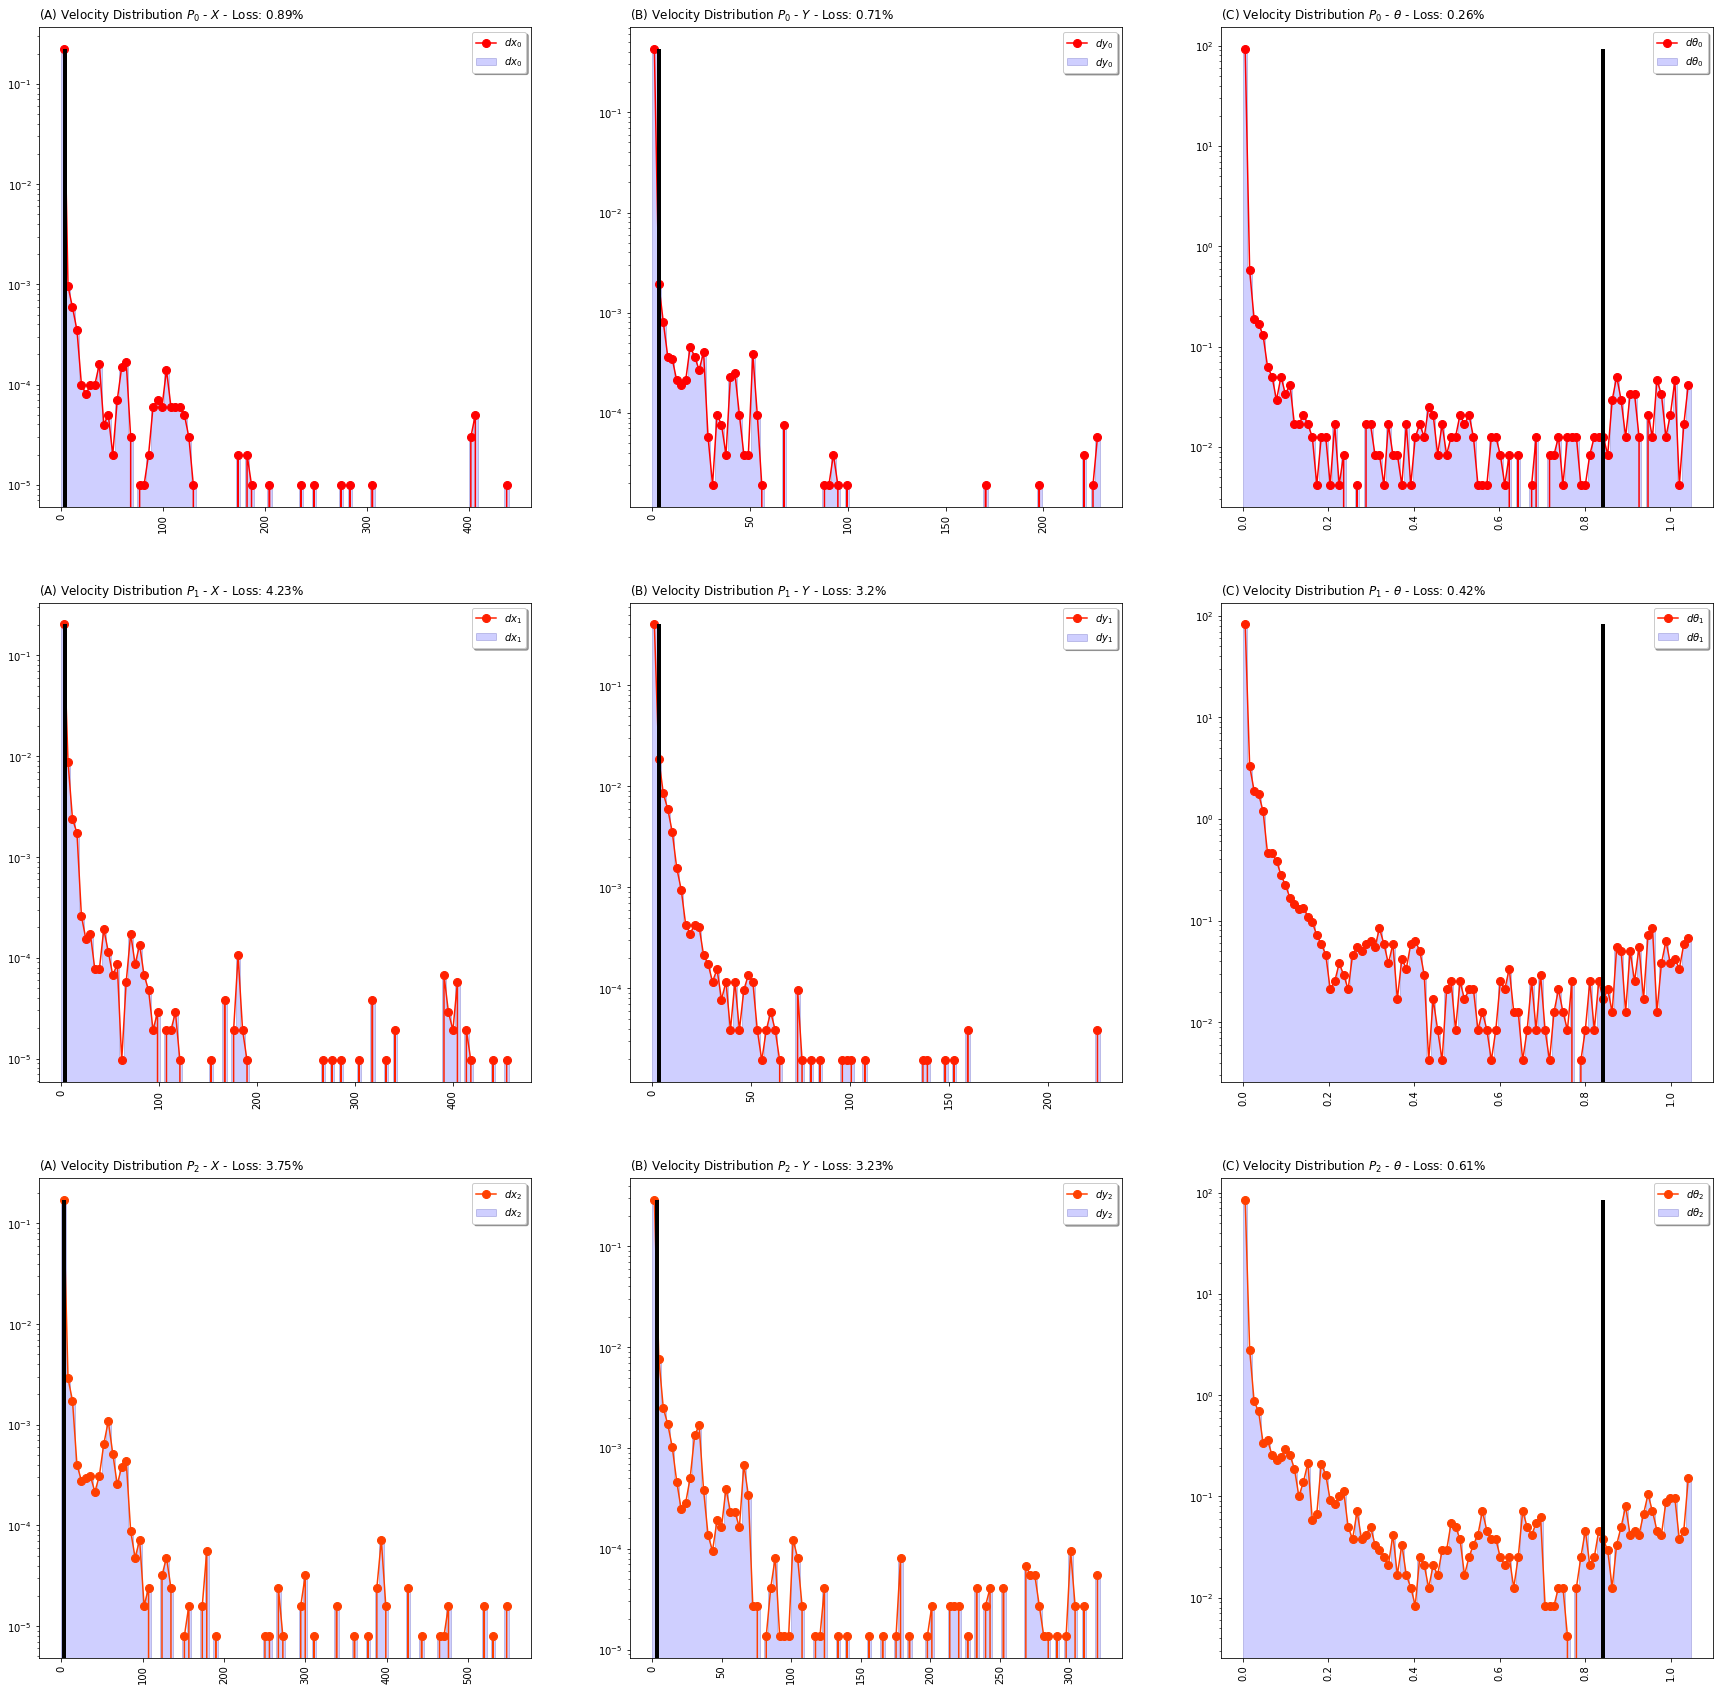

In [17]:
bins = 100
width = 10
fancy_legend = True
omega_threshold = df_tracked["velocity_orientation"].abs().quantile(0.965) # Angular velocity per frame
velocity_threshold = df_tracked["velocity_x"].abs().quantile(0.815) # Velocity per frame limited with half average size of particle
print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi, "\n")

plt_cp.plot_velocities_distribution(
    df_tracked=df_filter_clustered,
    bins=bins,
    velocity_threshold=velocity_threshold,
    omega_threshold=omega_threshold,
    width=width,
    fancy_legend=fancy_legend
)

In [18]:
if "coords_x" in df_filter_clustered.columns:
    df_filter_clustered.drop(columns=["coords_x", "coords_y"]).to_csv("{}/clustered_{}.csv".format(output_path, video_name), index=False)
else:
    df_filter_clustered.to_csv("{}/clustered_{}.csv".format(output_path, video_name), index=False)

In [19]:
df_filter_clustered.head(n_particles * 3)

,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count,delta_time,velocity_x,velocity_y,velocity_orientation,mask_x,mask_y,mask_orientation
0,0,0,1486.728940,147.959019,1469.665152,147.024816,0.0,1476.000000,102.000000,0.517647,1548.000000,176.000000,-1.528609,15373.0,246.752541,90.076766,0.930988,3,NaN,NaN,NaN,NaN,False,False,False
6189,1,0,1711.614925,526.955600,1709.537356,531.150816,NaN,1711.614925,526.955600,NaN,1711.614925,526.955600,0.204139,8536.0,167.370882,68.859411,0.911447,3,NaN,NaN,NaN,NaN,False,False,False
12379,2,0,1660.838686,941.598300,1657.665981,942.384271,NaN,1660.838686,941.598300,NaN,1660.838686,941.598300,0.857466,13886.0,247.304681,96.601980,0.920552,3,NaN,NaN,NaN,NaN,False,False,False
18568,0,3,1486.505365,148.195346,1469.463801,147.553996,0.0,1476.000000,102.000000,0.517647,1520.000000,176.000000,-1.524831,15470.0,246.889766,90.647556,0.930159,3,3.0,-0.074525,0.078776,0.001259,False,False,False
18569,1,3,1713.170943,527.236681,1711.572922,531.736339,NaN,1713.170943,527.236681,NaN,1713.170943,527.236681,-0.211180,8184.0,170.114269,63.021806,0.928845,3,3.0,0.518673,0.093694,-0.138440,False,False,False
18570,2,3,1660.304108,941.016360,1657.407658,941.964972,NaN,1660.304108,941.016360,NaN,1660.304108,941.016360,0.870132,14120.0,247.482570,98.398615,0.917560,3,3.0,-0.178193,-0.193980,0.004222,False,False,False
18571,0,6,1486.641042,148.180516,1469.652906,147.523009,0.0,1476.000000,102.000000,0.517647,1553.000000,176.000000,-1.525043,15428.0,246.688493,90.623443,0.930079,3,3.0,0.045226,-0.004943,-0.000071,False,False,False
18572,1,6,1713.103789,527.383969,1711.461069,531.975955,NaN,1713.103789,527.383969,NaN,1713.103789,527.383969,-0.212554,8209.0,170.457893,63.085933,0.928993,3,3.0,-0.022385,0.049096,-0.000458,False,False,False
18573,2,6,1657.570822,938.051950,1656.058165,940.088108,NaN,1657.570822,938.051950,NaN,1657.570822,938.051950,0.875249,14360.0,246.579700,98.528966,0.916697,3,3.0,-0.911095,-0.988137,0.001706,False,False,False


## Visualize final data

In [20]:
width = 10
n_x_breaks = 20
n_y_breaks = 20
x_bounds = x_bounds  # Range: [0, 1080]
y_bounds = y_bounds  # Range: [0, 1920]
x_zoom = None  # x_zoom
y_zoom = None  # y_zoom
fancy_legend = True
x_legend = 1.001
y_legend = 0.821

if save_figures:
    df_data = df_filter_clustered[["time", "id_count", "id"]].drop_duplicates()
    df_data["id_included"] = True
    df_data["orientation_included"] = True

    # for time in tqdm(df_filter_clustered["time"].unique()):
    for time in tqdm([0, 10, 20, 50, 100]):
        plt_tp.plot_tracking_frame(
            reader=reader,
            df_tracked_frame=df_filter_clustered,
            width=width,
            n_x_breaks=n_x_breaks,
            n_y_breaks=n_y_breaks,
            x_bounds=x_bounds,
            y_bounds=y_bounds,
            x_zoom=x_zoom,
            y_zoom=y_zoom,
            fancy_legend=fancy_legend,
            x_legend=x_legend,
            y_legend=y_legend,
            save_figure=True,
            output_path=output_path,
            output_name="{}_c".format(video_name),
            time=time
        )

    df_data.to_csv("{}/{}_c/df_control.csv".format(output_path, video_name), index=False)


100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


In [21]:
from shutil import make_archive

make_archive(
    "{}/{}_c".format(output_path, video_name),
    "zip",
    output_path,
    "{}/{}_c".format(output_path, video_name)
)

'/home/fabril/Github/High_Order_Interactions/tracking_videos/output_files/3n_2m_1f_230404_1_c.zip'